In [1]:
import matplotlib
matplotlib.use("nbagg")
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import re, os, glob, pickle, shutil,sys
from random import randint
import time
from shutil import *

os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
from theano import *
theano.__version__
from theano.sandbox.cuda import dnn

import pandas as pd
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams


from theano.compile.nanguardmode import NanGuardMode

#from pom_funcs import *
from pom_room import POM_room
from pom_evaluator import POM_evaluator
import POMLayers1
from EM_funcs import *
import ZtoY
config.allow_gc =False

%load_ext autoreload
%autoreload 2




### Run POM

In [ ]:
room = POM_room()
POMLayers1.room = room #TODO : modify POMLayers1 so that we don't need room, just config

a,p,alpha_black = 1.5,200,0.5

POMLauncher = POMLayers1.pomLayer()
POMLauncher.set_POM_params(a = a, alpha_black = alpha_black, prior_factor = p)


Q_out,Z_out,Shift = POMLauncher.run_POM(1,n_iter_pom = 300,step_0 = 0.002,use_unaries = True,T_0 = 10.0)
#room.save_dat(Q_out,fid,folder_out,verbose = True)

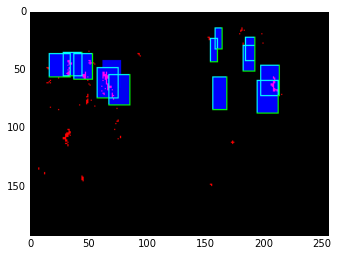

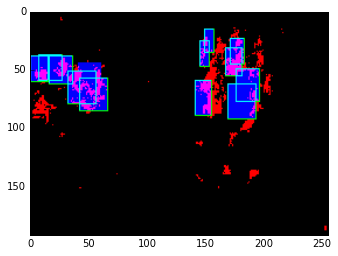

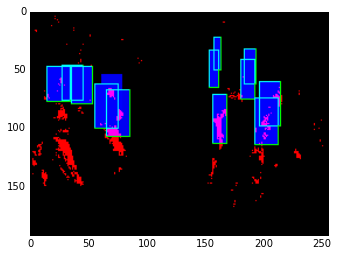

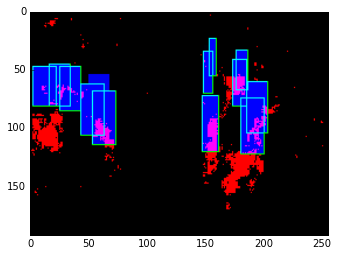

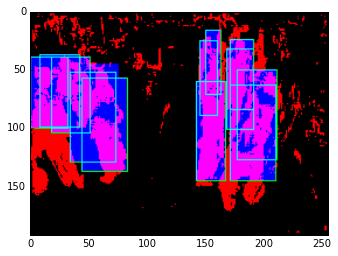

In [13]:
%matplotlib inline
room.plot_output(Q_out,0,1,0,thresh = 0.95,iteration=-1)
room.plot_output(Q_out,0,1,1,thresh = 0.95,iteration=-1)
room.plot_output(Q_out,0,1,2,thresh = 0.95,iteration=-1)
room.plot_output(Q_out,0,1,3,thresh = 0.95,iteration=-1)
room.plot_output(Q_out,0,1,8,thresh = 0.95,iteration=-1)
#room.plot_output(Q_out,0,1,1,thresh = 0.95,iteration=-10)

<IPython.core.display.Javascript object>


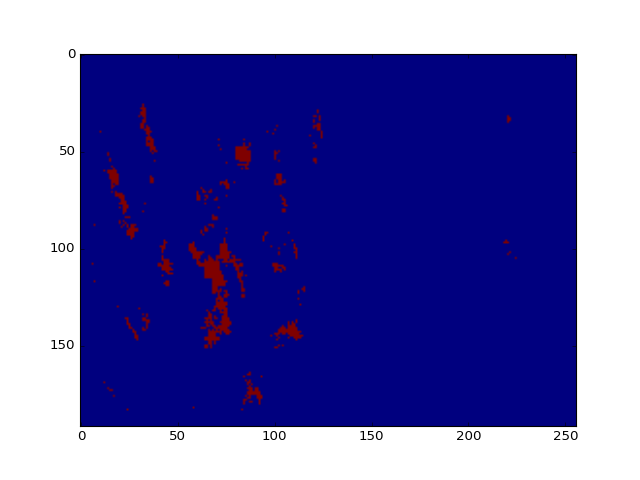

In [6]:
# test = np.load('./Potentials/Parts/EM5/c0/900.npy')
# plt.imshow(test[:,:,0])
# plt.show()

test1 = np.load('./Potentials/Parts/Run_transfer/c0/1.npy')
plt.imshow(test1[:,:,2])
plt.show()

In [ ]:
##### Run POM bulk

In [7]:
print room.parts_root_folder

./Potentials/Parts/Run/


In [5]:
import Config
room = POM_room()
POMLayers1.room = room 
room.img_index_list = range(2000,4000,5)
#TODO : modify POMLayers1 so that we don't need room, just config

a,p,alpha_black = 2.5,230,1.5

POMLauncher = POMLayers1.pomLayer()
POMLauncher.set_POM_params(a = a, alpha_black = alpha_black, prior_factor = p)

#optimised values
# POMLauncher.alphas.set_value(np.asarray([1.80283296,  1.80929637 , 1.88381839 , 1.6279335 ,  2.09338522 , 1.96566319,
#   1.78461742 , 2.05577421 , 0.        ]).astype(np.float32))
#Create folder
folder_out = './results/res_nounaries_a%f_p%f_ablack%f/'%(a,p,alpha_black)
if not os.path.exists(folder_out):
    os.makedirs(folder_out)

def runsave(fid,n_iter_pom = 300,step_0 = 0.002):
    last = len(room.img_index_list)
    if fid < last:
        Q_out,Z_out,Shift = POMLauncher.run_POM(fid,n_iter_pom = 300,step_0 = 0.002,use_unaries = False)
        room.save_dat(Q_out,fid,folder_out,verbose = True)
        #room.plot_output(Q_out,fid,1,8,thresh = 0.95,iteration=-1)


  

In [6]:
from joblib import Parallel, delayed
import multiprocessing

n_threads =40

for block in range(0,len(room.img_index_list)/n_threads+1):
    fids = range(n_threads*block,n_threads*(block+1))
    Parallel(n_jobs=n_threads)(delayed(runsave)(fid) for fid in fids)


Saved file : ./results/res_nounaries_a2.500000_p230.000000_ablack1.500000/00002170.dat
Saved file : ./results/res_nounaries_a2.500000_p230.000000_ablack1.500000/00002180.dat
Saved file : ./results/res_nounaries_a2.500000_p230.000000_ablack1.500000/00002185.dat
Saved file : ./results/res_nounaries_a2.500000_p230.000000_ablack1.500000/00002155.dat
Saved file : ./results/res_nounaries_a2.500000_p230.000000_ablack1.500000/00002195.dat
Saved file : ./results/res_nounaries_a2.500000_p230.000000_ablack1.500000/00002150.dat
Saved file : ./results/res_nounaries_a2.500000_p230.000000_ablack1.500000/00002065.dat
Saved file : ./results/res_nounaries_a2.500000_p230.000000_ablack1.500000/00002160.dat
Saved file : ./results/res_nounaries_a2.500000_p230.000000_ablack1.500000/00002130.dat
Saved file : ./results/res_nounaries_a2.500000_p230.000000_ablack1.500000/00002135.dat
Saved file : ./results/res_nounaries_a2.500000_p230.000000_ablack1.500000/00002175.dat
Saved file : ./results/res_nounaries_a2.500

### Run Baseline

In [3]:
from joblib import Parallel, delayed
import multiprocessing

room = POM_room()
POMLayers1.room = room #TODO : modify POMLayers1 so that we don't need room, just config
a,p,alpha_black = 1.8,270,0.0

POMLauncher = POMLayers1.pomLayer()
POMLauncher.set_POM_params(a = a, alpha_black = alpha_black, prior_factor = p)



thresh = 0.05
radius = 4

#print 'Setting a = %f, p = %f'%(a,p)

folder_out = './results/res_NMS_t%f_rad%f/'%(thresh,radius)
if not os.path.exists(folder_out):
    os.makedirs(folder_out)
   

def runsave(fid):
    Q_out = POMLauncher.run_NMS(fid,room,rad = radius,thresh_p  = thresh)
    room.save_dat(Q_out,fid,folder_out)
    

n_threads =40

for block in range(0,len(room.img_index_list)/n_threads+1):
    fids = range(n_threads*block,n_threads*(block+1))
    Parallel(n_jobs=n_threads)(delayed(runsave)(fid) for fid in fids)




KeyboardInterrupt: 

### Test

<IPython.core.display.Javascript object>


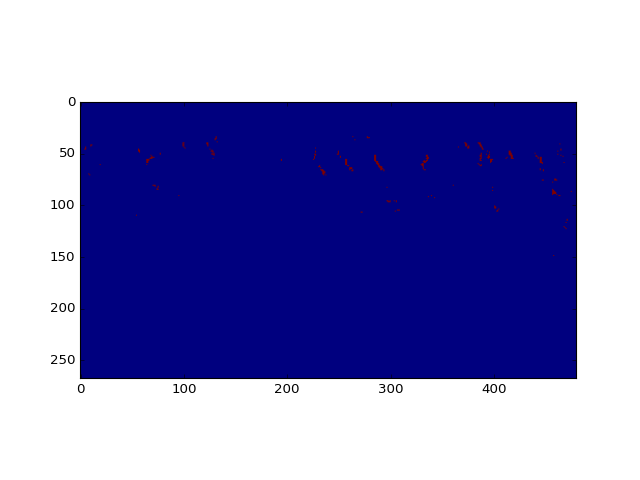

<IPython.core.display.Javascript object>


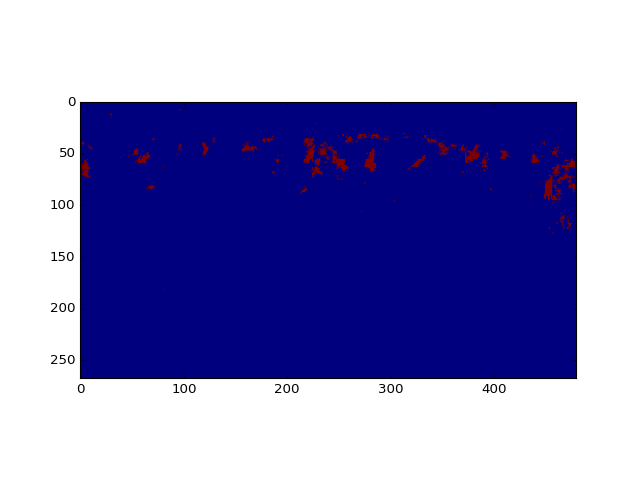

<IPython.core.display.Javascript object>


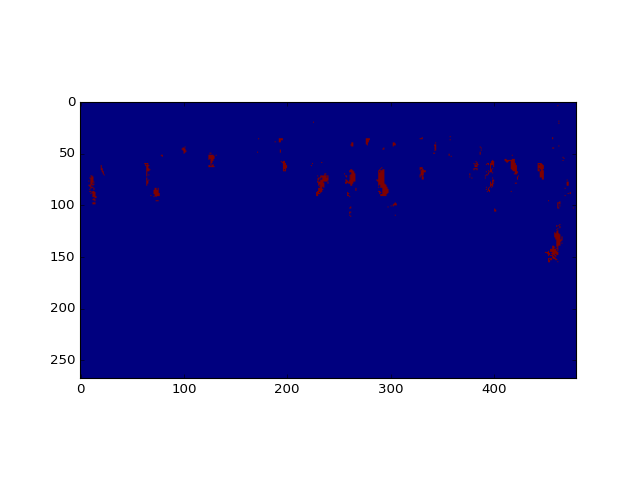

<IPython.core.display.Javascript object>


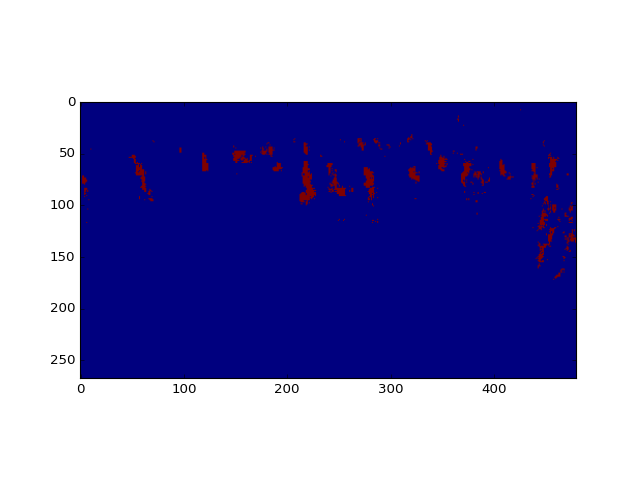

<IPython.core.display.Javascript object>


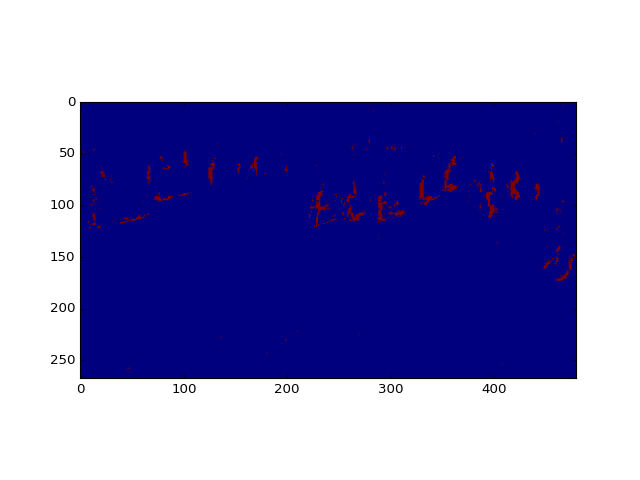

<IPython.core.display.Javascript object>


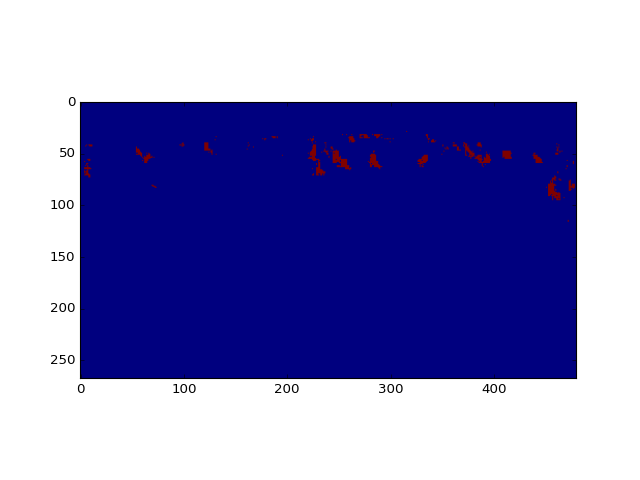

<IPython.core.display.Javascript object>


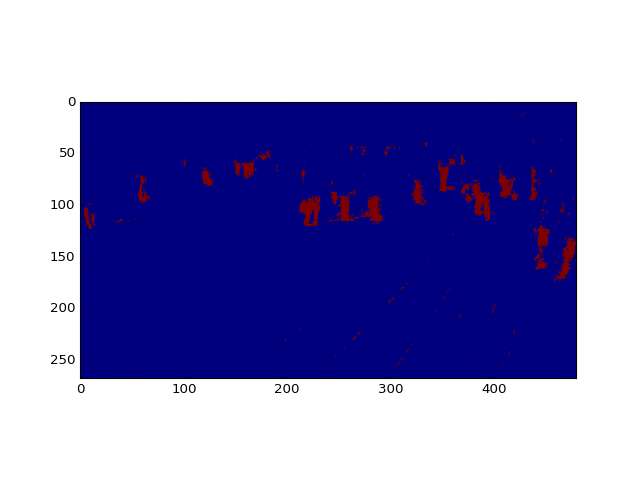

<IPython.core.display.Javascript object>


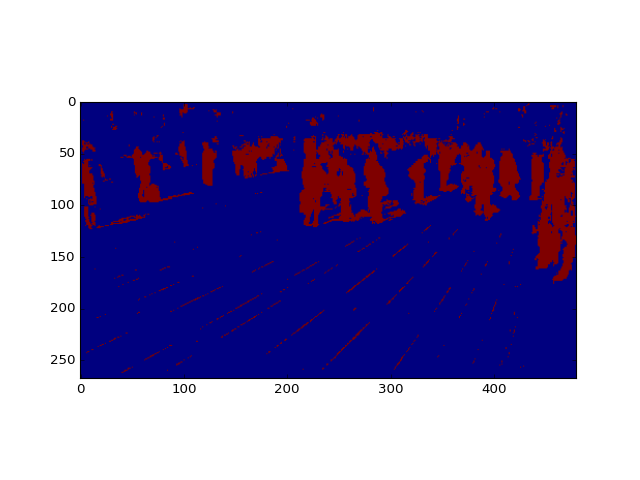

In [20]:
parts = np.load('./Potentials/Parts/Run/c0/850.npy')
plt.imshow(parts[:,:,0])
plt.show()

plt.imshow(parts[:,:,1])
plt.show()

plt.imshow(parts[:,:,2])
plt.show()

plt.imshow(parts[:,:,3])

plt.imshow(parts[:,:,4])
plt.show()

plt.imshow(parts[:,:,5])
plt.show()

plt.imshow(parts[:,:,6])
plt.show()
plt.imshow(parts[:,:,7])
plt.show()

plt.imshow(parts[:,:,8])
plt.show()

from PIL import Image
im = Image.fromarray(np.uint8((parts[:,:,0]>0.2)*250.))
im.save('./test.png')


In [34]:
test = np.asarray([[0,1],[2,3]])
print test[0]
test_re = test.reshape((4))
print test_re

[0 1]
[0 1 2 3]
